## Example on utilizing exper knowledge

This example is copied from *Introduction to Machine Learning with Python* and serves as a personal knowledge base only

In [1]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge

The citibike dataframe contains the number of bike rentals per 3 hours

In [2]:
citibike = mglearn.datasets.load_citibike()
citibike.head(8)

c:\Users\LuukvanRoessel\Anaconda3\envs\ml-luuk\lib\site-packages\mglearn\datasets.py:57: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_resampled = data_starttime.resample("3h").sum().fillna(0)


starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
2015-08-01 15:00:00    27
2015-08-01 18:00:00    12
2015-08-01 21:00:00     4
Freq: 3H, Name: one, dtype: int64

Text(0, 0.5, 'Rentals')

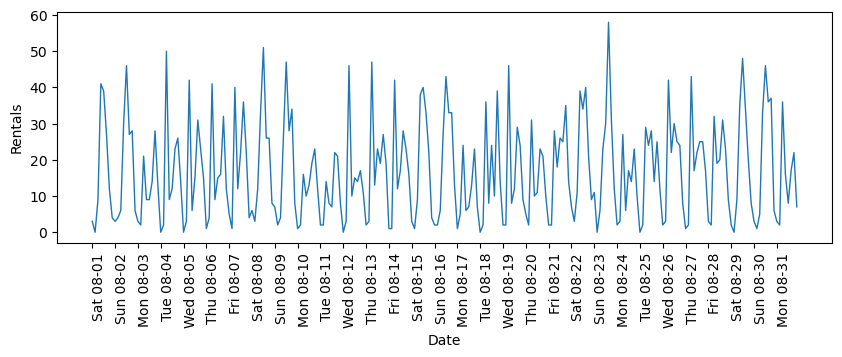

In [3]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(citibike.index.min(), citibike.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

First, naively assume UNIX time as a feature and train a random forest on part of our data set, to predict for the test set ('future' data). To automate, we create function `eval_on_features`

In [4]:
y = citibike.values
X = citibike.index.astype("int64").values.reshape(-1, 1)//10**9

In [5]:
n_train = 184
def eval_on_features(features, target, regressor):
    # Split into a training and test dataset
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]

    #train and predict
    regressor.fit(X_train, y_train)
    print(f'Test-set R^2: {regressor.score(X_test, y_test)}')
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)

    #plotting
    plt.figure(figsize = (10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test-set R^2: -0.035486463625959086


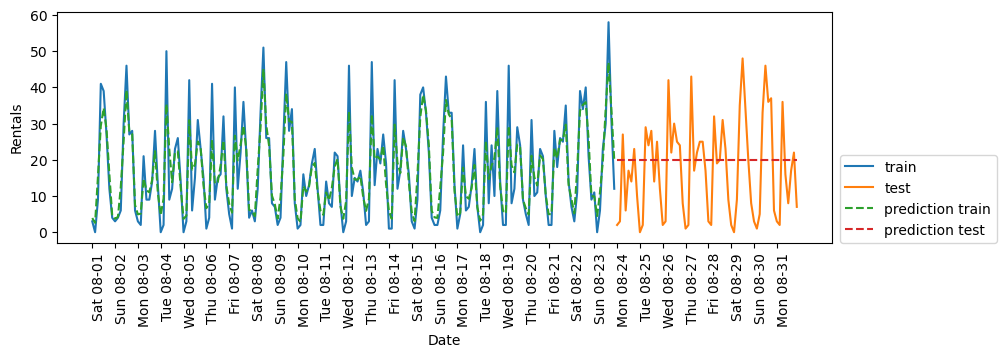

In [6]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

Clearly, the randomforrestregressor is unable to predict, logically because the feature entails UNIX time; an increasing number of seconds. 'Future' seconds simply fall outside of the range of unix seconds the model was trained on. Therefore, for future seconds, the model fills in the same estimate for future seconds.

### Improving our features

We can improve using expert knowledge. By eye, we can see a recurring pattern on levels: 1) moment of day, 2) day of the week. If we manually create features that represent these levels, we're training our model on more valuable information.

Test-set R^2: 0.8419488587966024


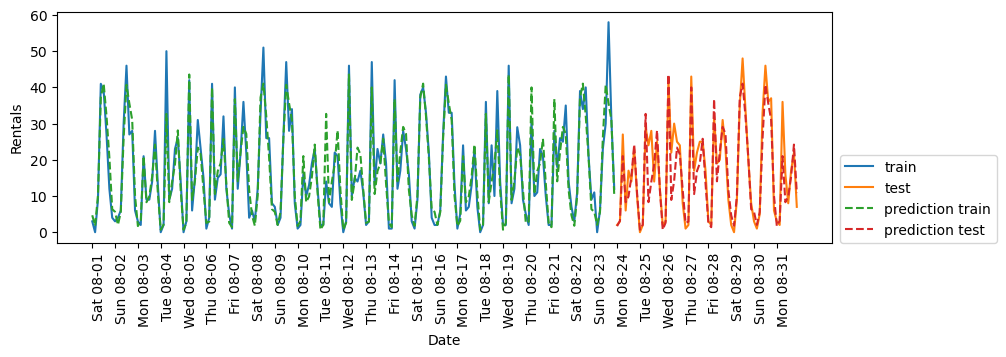

In [7]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1), citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

### Obtaining similar results using a linear model and data manipulation

We can achieve similar results using simple linear regression
- Explicitly define our feature data as categorical data, e.g. using one-hot-encoding
- Add interaction features that resemble the interaction between specific day of the moment and day of the week (if we won't do this, the model learn (and predict) based on an average value for each day of the week and for each moment of the day (without interaction between the two).

In [8]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Test-set R^2: 0.8451706357968557


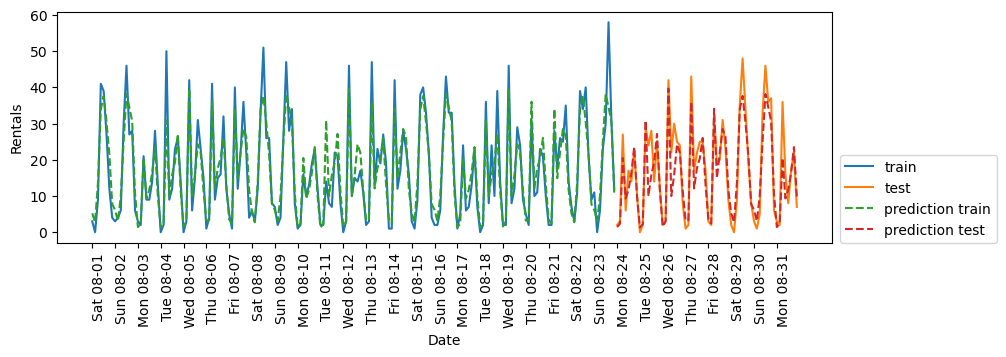

In [9]:
poly_tranformer = PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_tranformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)